# CIFAR 100_Project

## CIFAR 100 VS CIFAR 10

### 1. 기본적인 차이점
#### 클래스 수
- CIFAR-10 : 10개 클래스
- CIFAR-100 : 100개 클래스 -> 모델 출력층을 100개로 설정해야함
#### 2. 이미지 특성
- 공통점: 둘 다 32x32x3 컬러 이미지
- 차이점: 클래스 세분화 정도
#### 3. 난이도 차이
**CIFAR-100 특성**
- 세밀한 구분: 100종류의 동물, 차량, 가구 등
- 훨씬 어려움: 같은 모델로 20-30% 수준
- 데이터 부족: 클래스당 500개로 학습 어려움
#### 4. CIFAR-100의 추가 특징
*계층구조*
- CIFAR-100은 20개의 상위 클래스(superclass)를 가짐

*학습 난이도 요인*
1. 클래스 간 유사성: 비슷한 클래스 구분이 어려움
2. 데이터 부족: 클래스당 500개는 딥러닝에 부족
3. 세밀한 특징 필요: 더 깊고 복잡한 모델 필요 

## 모델 개선 순서
1. 모델 구조 개선 (CNN)
2. Data Augmentation
3. Batch Norm/Dropout
4. Learning Rate
5. Optimzer 선택
6. Batch Size
7. Epochs 수
8. Weight Decay

In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split

In [2]:
# Data Augmentation 셀
import torchvision.transforms as transforms

# ========= Data Augmentation 설정 =========

# Training용 Transform (Augmentation 포함)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding= 4),
    transforms.RandomHorizontalFlip(p= 0.5),
    transforms.ColorJitter(brightness=0.2, contrast= 0.2, saturation= 0.2, hue= 0.1),
    transforms.ToTensor(),
    transforms.Normalize(
        mean= [0.5071, 0.4867, 0.4408],
        std = [0.2675, 0.2565, 0.2761]
    ),
])

# Validation/ Test용 Transform (Augmentation 없음)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.5071, 0.4867, 0.4408],
        std = [0.2675, 0.2565, 0.2761]
    )
])

print("✅ Data Augmentation transforms created")

✅ Data Augmentation transforms created


In [3]:
# CIFAR100 데이터셋 로드(Augmentation 적용)

# Train 데이터 (Augmentation 적용)
cifar100_train_aug = datasets.CIFAR100(
    root= './data',
    train= True,
    download= True,
    transform= train_transform # Augmentation 적용
)

# Validation 데이터 (Augmentation 없음)
cifar100_train_no_aug = datasets.CIFAR100(
    root= './data',
    train= True,
    download= True,
    transform= test_transform # Augmentation 없음
)

# Train / Validation 분할
# 시드 고정 추가
torch.manual_seed(42)
train_dataset, _ = random_split(cifar100_train_aug, [40000, 10000])

torch.manual_seed(42)
_, val_dataset = random_split(cifar100_train_no_aug, [40000, 10000])

# Test 데이터
test_dataset = datasets.CIFAR100(
    root= './data',
    train= False,
    download= True,
    transform= test_transform
)

# 시각화용 원본 데이터
cifar100_dataset = datasets.CIFAR100(
    root= './data',
    train= True,
    download= True,
    transform= transforms.ToTensor()
)

print("Data loaded with Augmentation(seed=42)")
print(f"    Train: {len(train_dataset)} (with augmentation)")
print(f"    Val: {len(val_dataset)} (no augmentation)")
print(f"    Test: {len(test_dataset)} (no augmentation)")

100%|██████████| 169M/169M [01:18<00:00, 2.15MB/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Data loaded with Augmentation(seed=42)
    Train: 40000 (with augmentation)
    Val: 10000 (no augmentation)
    Test: 10000 (no augmentation)


In [4]:
# DataLoader (batch 단위로 데이터 공급)
device = torch.device("cpu")
print(f"Using device: {device}")

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    #추가
    num_workers=0,      
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    # 추가
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    # 추가
    num_workers=0
)

Using device: cpu


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7637602..1.8635707].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8974658..2.0111496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7344401..1.7412844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8974658..1.3284639].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8974658..0.6258311].


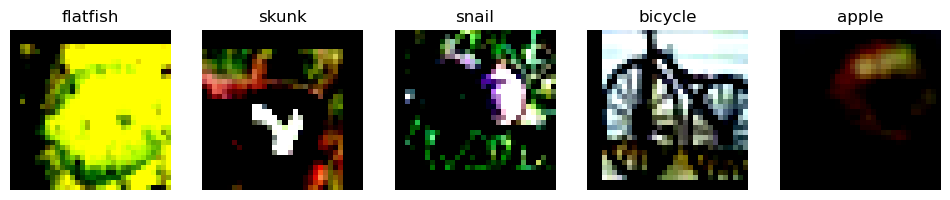

In [5]:
import matplotlib.pyplot as plt

# 데이터 확인: train_loader에서 샘플 몇 개 가져오기
classes = cifar100_dataset.classes  # ['airplane', 'automobile', ..., 'truck']

plt.figure(figsize=(12, 3))
for i in range(5):
    img, label = train_dataset[i]
    np_img = img.numpy().transpose((1, 2, 0))
    plt.subplot(1, 5, i+1)
    plt.imshow(np_img)
    plt.title(classes[label])
    plt.axis('off')
plt.show()


In [6]:
############# TODO: 모델 선언하기 (주의: 이미지 크기 달라짐)
import torch.nn.functional as F

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding= 1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding= 1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding= 1)
        self.bn3 = nn.BatchNorm2d(128)

        # New: extra conv to increase RF from 22 -> 38 (covers full 32x32)
        self.conv4 = nn.Conv2d(128, 128, 3, padding= 1)
        self.bn4 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.gap = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling

        # Simpler head: 128 -> 100
        self.fc = nn.Linear(128, 100)

        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        # Block 1: 32x32 -> 16x16
        x = self.pool(F.relu(self.bn1(self.conv1(x))))

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)

        # Block 4: 4x4 (RF 확장용, 크기 유지)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)

        # GAP: 4x4 -> 1x1
        x = self.gap(x) # (N, 128, 1, 1)

        # Flatten : (N, 128, 1 1) -> (N, 128)
        x = x.view(x.size(0), -1)

        # Dropout + FC
        x = self.dropout(x)
        x = self.fc(x)
        
        return x


In [7]:
model = ImprovedCNN()
print(model)
print(f"\nTotal params: {sum(p.numel() for p in model.parameters()):,}")

# 더미 입력으로 forward 테스트
x_test = torch.randn(2, 3, 32, 32)
y_test = model(x_test)
print(f"Input: {x_test.shape} -> Output: {y_test.shape}")  # (2,3,32,32) -> (2,100)

ImprovedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveAvgPool2d(output_size=1)
  (fc): Linear(in_features=128, out_features=100, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Total params: 254,436
Input: torch.Size([2, 3, 32, 32]) -> Output: torch.Size([2, 100

In [ ]:
########### 학습 할 때 마다 해당 셀 꼭 다시 실행하기!!!! ###########

############# TODO: 모델 생성, 손실함수, 옵티마이저 정의하기
model = ImprovedCNN()

# Label smoothing helps CIFAR-100
criterion = nn.CrossEntropyLoss(label_smoothing= 0.1)

# Add weight decay for generalization
optimizer = optim.AdamW(model.parameters(), lr = 1e-3, weight_decay= 5e-4)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode= 'max',
    factor= 0.5,
    patience= 5
    )

# Early Stopping 설정
best_val_acc= 0
patience= 10
patience_counter= 0
best_model_state= None

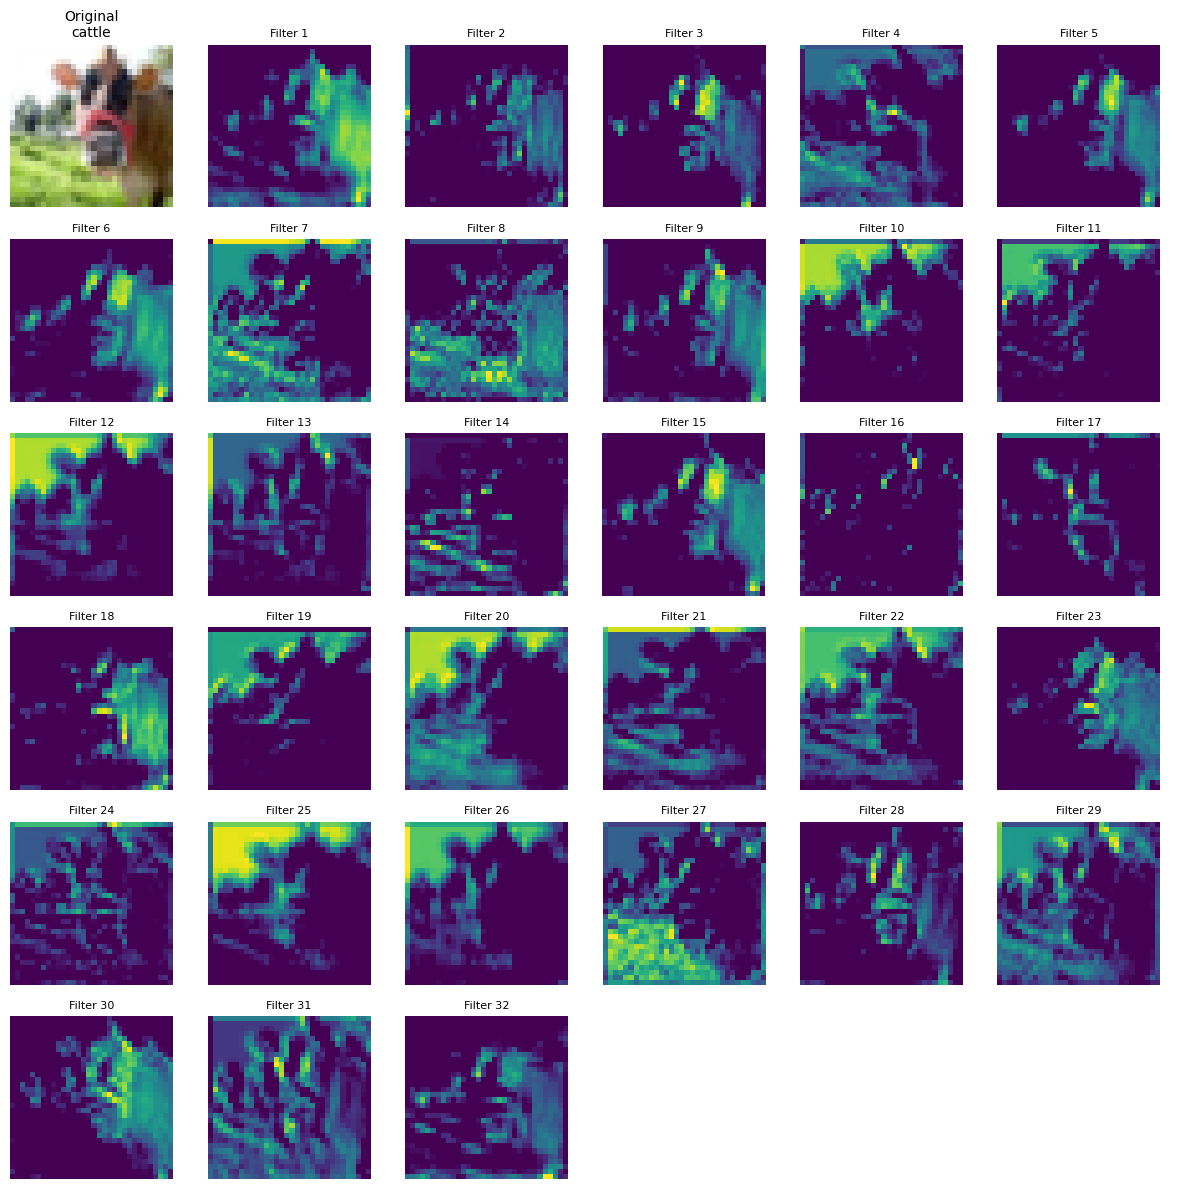

In [9]:
def visualize_feature_maps_safe(model, image_idx=0):
    """안전한 feature map 시각화"""
    from PIL import Image
    import numpy as np
    
    # 1) 원본 데이터 로드
    dataset_raw = datasets.CIFAR100(root='./data', train=True, download=False, transform=None)
    img_pil, label = dataset_raw[image_idx]
    img_original = np.array(img_pil)
    
    # 2) 모델 입력용 (정규화 적용)
    img_tensor = test_transform(img_pil).unsqueeze(0)
    
    # 3) Forward pass (첫 번째 Conv layer만)
    model.eval()
    with torch.no_grad():
        x = model.conv1(img_tensor)
        x = model.bn1(x)
        x = F.relu(x)
    
    # 4) 시각화 설정
    n_filters = x.shape[1]  # 32
    n_cols = 6
    n_rows = (n_filters + n_cols) // n_cols  # 원본 포함해서 필요한 행 수
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
    axes = axes.flatten()  # 1D 배열로 변환
    
    # 첫 번째 subplot: 원본 이미지
    axes[0].imshow(img_original)
    axes[0].set_title(f'Original\n{classes[label]}', fontsize=10)
    axes[0].axis('off')
    
    # 나머지 subplot: Feature maps
    for i in range(n_filters):
        feature_map = x[0, i].cpu().numpy()
        axes[i+1].imshow(feature_map, cmap='viridis')
        axes[i+1].set_title(f'Filter {i+1}', fontsize=8)
        axes[i+1].axis('off')
    
    # 남은 빈 subplot 제거
    for i in range(n_filters+1, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# 실행
visualize_feature_maps_safe(model, image_idx=0)

In [10]:
def analyze_model(model):
    """모델의 각 레이어별 분석"""
    print("=" * 90)
    print(f"{'Layer':<24} {'Output Shape':<20} {'Params':<12} {'RF':<6} {'Jump'}")
    print("=" * 90)

    x = torch.randn(1, 3, 32, 32)
    rf, jump = 1, 1

    def process_layer(name, module, kernel_size=None, stride=None):
        nonlocal x, rf, jump
        x = module(x)
        params = sum(p.numel() for p in module.parameters())
        
        # RF 업데이트
        if kernel_size and stride:
            rf = rf + (kernel_size - 1) * jump
            jump = jump * stride
        
        print(f"{name:<24} {str(tuple(x.shape)):<20} {params:<12} {rf:<6} {jump}")
        return x

    # Conv1 Block
    process_layer("Conv1 (3x3, p=1)", model.conv1, kernel_size=3, stride=1)
    process_layer("BatchNorm1", model.bn1)
    x = F.relu(x)
    process_layer("MaxPool1 (2x2)", model.pool, kernel_size=2, stride=2)

    # Conv2 Block
    process_layer("Conv2 (3x3, p=1)", model.conv2, kernel_size=3, stride=1)
    process_layer("BatchNorm2", model.bn2)
    x = F.relu(x)
    process_layer("MaxPool2 (2x2)", model.pool, kernel_size=2, stride=2)

    # Conv3 Block
    process_layer("Conv3 (3x3, p=1)", model.conv3, kernel_size=3, stride=1)
    process_layer("BatchNorm3", model.bn3)
    x = F.relu(x)
    process_layer("MaxPool3 (2x2)", model.pool, kernel_size=2, stride=2)

    # Conv4 Block (새로 추가)
    process_layer("Conv4 (3x3, p=1)", model.conv4, kernel_size=3, stride=1)
    process_layer("BatchNorm4", model.bn4)
    x = F.relu(x)

    # GAP + FC
    process_layer("GAP", model.gap)
    x = x.view(x.size(0), -1)
    process_layer("Dropout", model.dropout)
    process_layer("FC (128->100)", model.fc)

    print("=" * 90)
    total = sum(p.numel() for p in model.parameters())
    print(f"\nTotal Parameters: {total:,}")
    print(f"Final RF: {rf}×{rf} pixels (Image: 32×32)")
    print(f"Coverage: {(rf/32)*100:.1f}%")

analyze_model(model)

Layer                    Output Shape         Params       RF     Jump
Conv1 (3x3, p=1)         (1, 32, 32, 32)      896          3      1
BatchNorm1               (1, 32, 32, 32)      64           3      1
MaxPool1 (2x2)           (1, 32, 16, 16)      0            4      2
Conv2 (3x3, p=1)         (1, 64, 16, 16)      18496        8      2
BatchNorm2               (1, 64, 16, 16)      128          8      2
MaxPool2 (2x2)           (1, 64, 8, 8)        0            10     4
Conv3 (3x3, p=1)         (1, 128, 8, 8)       73856        18     4
BatchNorm3               (1, 128, 8, 8)       256          18     4
MaxPool3 (2x2)           (1, 128, 4, 4)       0            22     8
Conv4 (3x3, p=1)         (1, 128, 4, 4)       147584       38     8
BatchNorm4               (1, 128, 4, 4)       256          38     8
GAP                      (1, 128, 1, 1)       0            38     8
Dropout                  (1, 128)             0            38     8
FC (128->100)            (1, 100)            

In [11]:

def compute_rf(layers):
    rf, jump = 1, 1
    trace = []
    for name,k,stride in layers:
        rf = rf + (k-1) * jump
        jump = jump * stride
        trace.append((name, rf, jump))
    return trace

seq = [
    ("Conv1",3,1),
    ("Pool1",2,2),
    ("Conv2",3,1),
    ("Pool2",2,2),
    ("Conv3",3,1),
    ("Pool3",2,2),
    ("Conv4",3,1)
]

for name, rf, jump in compute_rf(seq):
    print(f"{name:6s} -> RF={rf}, jump={jump}")

Conv1  -> RF=3, jump=1
Pool1  -> RF=4, jump=2
Conv2  -> RF=8, jump=2
Pool2  -> RF=10, jump=4
Conv3  -> RF=18, jump=4
Pool3  -> RF=22, jump=8
Conv4  -> RF=38, jump=8


In [12]:
import time
import copy

num_epochs = 40
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()

    # ---- Training ----
    model.train()  # 학습 모드
    train_loss, correct = 0, 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)        
        loss = criterion(outputs, labels)           
        loss.backward()              
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    train_acc = correct / len(train_dataset)
    train_loss /= len(train_loader)

    # ---- Validation ----
    model.eval()  # 평가 모드
    val_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)       
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

    val_acc = correct / len(val_dataset)
    val_loss /= len(val_loader)

    # Learning Rate Scheduling
    old_lr = optimizer.param_groups[0]['lr']    # 변경 전 LR 저장
    scheduler.step(val_acc)
    current_lr = optimizer.param_groups[0]['lr']    # 변경 후 LR

    if current_lr != old_lr:
        print(f"\n LR reduced: {old_lr:.6f} -> {current_lr:.6f}")

    # Early Stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        best_model_state = copy.deepcopy(model.state_dict())
        status = "Best"
    else:
        patience_counter += 1
        status = f"({patience_counter}/{patience})"

        if patience_counter >= patience:
            print(f"\n Early Stopping at Epoch {epoch + 1}")
            break
    
    epoch_time = time.time() - epoch_start
    elapsed = time.time() - start_time

    print(f"Epoch [{epoch+1:2d}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} {status}"
          f"\nLR: {current_lr:.6f} [{epoch_time:.1f}s, {elapsed/60:.1f}min]")

# 최고 모델 복원
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nMode; restored to best state")

total_time = time.time() - start_time
print(f"\n Training complete in {total_time/60:.1f}minutes")
print(f"Best Val Accuracy: {best_val_acc:.4f}")


Epoch [ 1/40] Train Loss: 4.1053, Train Acc: 0.0896 | Val Loss: 3.7400, Val Acc: 0.1494 Best
LR: 0.001000 [49.0s, 0.8min]
Epoch [ 2/40] Train Loss: 3.6659, Train Acc: 0.1729 | Val Loss: 3.5072, Val Acc: 0.2072 Best
LR: 0.001000 [50.0s, 1.7min]
Epoch [ 3/40] Train Loss: 3.4547, Train Acc: 0.2201 | Val Loss: 3.2702, Val Acc: 0.2651 Best
LR: 0.001000 [49.9s, 2.5min]
Epoch [ 4/40] Train Loss: 3.3046, Train Acc: 0.2555 | Val Loss: 3.1322, Val Acc: 0.3098 Best
LR: 0.001000 [47.6s, 3.3min]
Epoch [ 5/40] Train Loss: 3.2076, Train Acc: 0.2826 | Val Loss: 3.0573, Val Acc: 0.3227 Best
LR: 0.001000 [47.6s, 4.1min]
Epoch [ 6/40] Train Loss: 3.1299, Train Acc: 0.3027 | Val Loss: 2.9659, Val Acc: 0.3523 Best
LR: 0.001000 [47.7s, 4.9min]
Epoch [ 7/40] Train Loss: 3.0539, Train Acc: 0.3225 | Val Loss: 2.9183, Val Acc: 0.3652 Best
LR: 0.001000 [47.6s, 5.7min]
Epoch [ 8/40] Train Loss: 3.0086, Train Acc: 0.3369 | Val Loss: 2.8967, Val Acc: 0.3661 Best
LR: 0.001000 [49.4s, 6.5min]
Epoch [ 9/40] Train Loss

In [ ]:
model.eval()
test_loss, correct = 0, 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

test_acc = correct / len(test_dataset)
test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 2.3862, Test Accuracy: 0.5163


In [20]:
# Confusion Matrix 생성
from sklearn.metrics import confusion_matrix
import numpy as np

# 모델의 모든 예측 수집
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # CPU로 이동 후 numpy 배열로 변환
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix 생성
cm = confusion_matrix(all_labels, all_preds)

# 확인
print(f"Confusion Matrix Shape: {cm.shape}")  # (100, 100)
print(f"Total Samples: {cm.sum()}")  # 10000
print(f"Correct Predictions: {np.diag(cm).sum()}")

Confusion Matrix Shape: (100, 100)
Total Samples: 10000
Correct Predictions: 5163


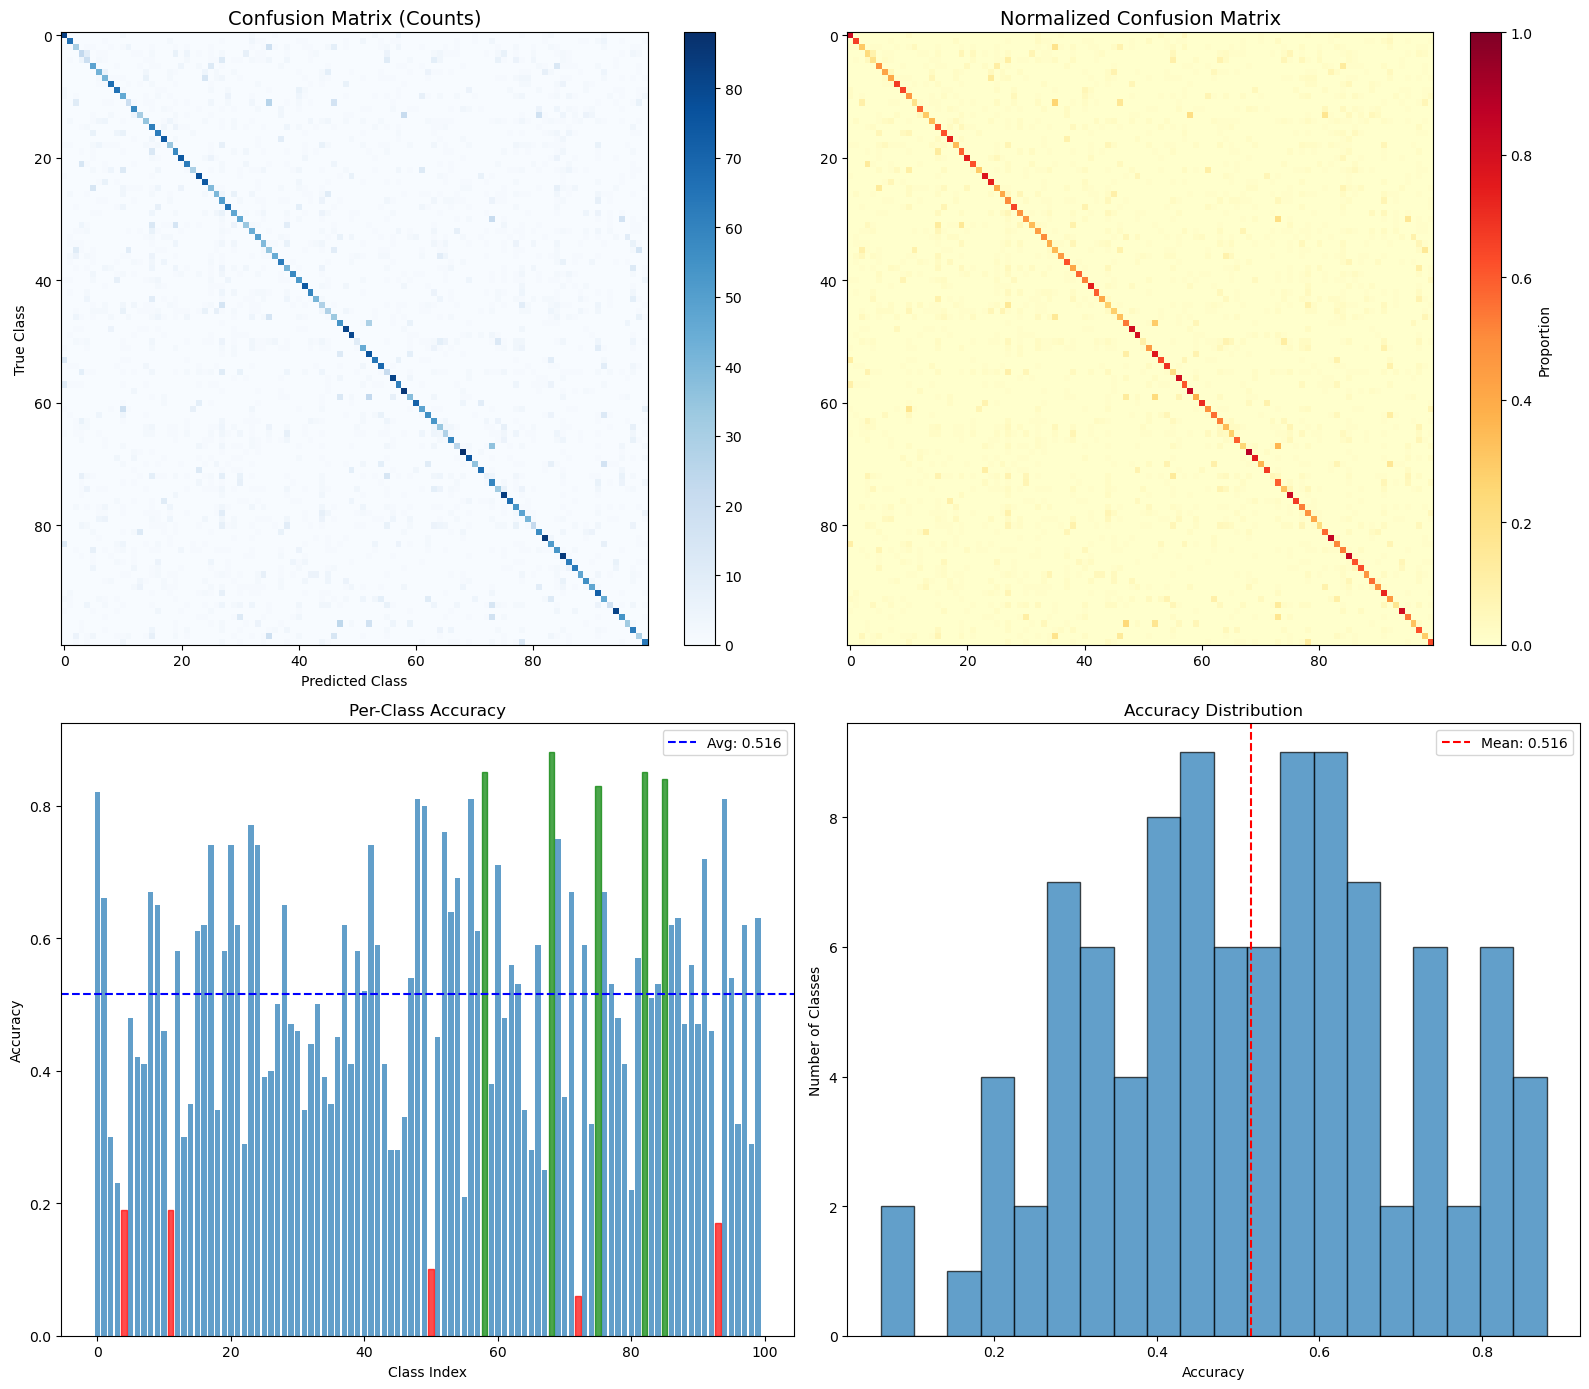

In [22]:
# 시각화 개선
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1) 전체 히트맵
im1 = axes[0, 0].imshow(cm, cmap='Blues', aspect='auto')
axes[0, 0].set_title('Confusion Matrix (Counts)', fontsize=14)
axes[0, 0].set_xlabel('Predicted Class')
axes[0, 0].set_ylabel('True Class')
plt.colorbar(im1, ax=axes[0, 0])

# 2) 정규화 버전
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
im2 = axes[0, 1].imshow(cm_norm, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
axes[0, 1].set_title('Normalized Confusion Matrix', fontsize=14)
plt.colorbar(im2, ax=axes[0, 1], label='Proportion')

# 3) 클래스별 정확도
class_acc = np.diag(cm) / cm.sum(axis=1)
bars = axes[1, 0].bar(range(100), class_acc, alpha=0.7)
top_5 = np.argsort(class_acc)[-5:]
bottom_5 = np.argsort(class_acc)[:5]
for idx in top_5:
    bars[idx].set_color('green')
for idx in bottom_5:
    bars[idx].set_color('red')
axes[1, 0].axhline(class_acc.mean(), color='blue', linestyle='--', 
                    label=f'Avg: {class_acc.mean():.3f}')
axes[1, 0].set_xlabel('Class Index')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Per-Class Accuracy')
axes[1, 0].legend()

# 4) 정확도 분포 히스토그램
axes[1, 1].hist(class_acc, bins=20, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(class_acc.mean(), color='red', linestyle='--', 
                    label=f'Mean: {class_acc.mean():.3f}')
axes[1, 1].set_xlabel('Accuracy')
axes[1, 1].set_ylabel('Number of Classes')
axes[1, 1].set_title('Accuracy Distribution')
axes[1, 1].legend()

plt.tight_layout()
plt.show()